# Plotting: Data

This notebook is used to generate all the "data" plots (samples, distribution of IDs, etc) in the paper.

## Setup

In [1]:
plot_dir = "../plots/"
data_base = "../data/"

num_samples = 11000

In [2]:
import os
import functools
from tqdm import tqdm

from util.data import Database, ArrayDataset, TFRecordLoader

2024-01-15 12:31:39.126887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

colors = [
    (190, 15, 52),
    (72, 145, 220),
    (0, 119, 112),
    (207, 122, 48),
    (235, 196, 203),
]
colors_hex = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in colors]

colors_gradient = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in
    [
        (235, 196, 203),
        (190, 15, 52),
        (135, 36, 52)
    ]
]
colors_gradient_str = ','.join(colors_gradient)
palette_gradient = sns.color_palette(f"blend:{colors_gradient_str}", as_cmap=True)

colors_gradient_blue = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in
    [
        (158, 206, 235),
        (72, 145, 220),
        (0, 33, 71),
    ]
]
colors_gradient_str_blue = ','.join(colors_gradient_blue)
palette_gradient_blue = sns.color_palette(f"blend:{colors_gradient_str_blue}", as_cmap=True)

#palette = 'colorblind'
palette = colors_hex
sns.set_theme(palette=palette)
sns.set_style('ticks')
sns.set_context('notebook')

plt.rcParams['figure.dpi'] = 72

## Loading Data

In [5]:
# Files to exclude for the "amount of data" plots
to_exclude = [
    f"db-{i}.sqlite3"
    for i in list(range(3, 13)) + [91]
]

In [6]:
def load_data(noise: int, to_exclude: list[str] = [], verbose: bool = False):
    if noise < 0 or noise > 100:
        raise ValueError("Noise must be between 0 and 100")

    samples_arrays = []
    ids_arrays = []
    cells_arrays = []

    # Load all sqlite3 files in the data path
    data_path = os.path.join(data_base, str(noise))
    for file in os.listdir(data_path):
        if file.endswith(".sqlite3") and file not in to_exclude:
            db = Database(os.path.join(data_path, file), num_samples, verbose=verbose)
            samples_array, ids_array, cells_array = db.to_arrays(cell=True)

            samples_arrays.append(samples_array)
            ids_arrays.append(ids_array)
            cells_arrays.append(cells_array)

    # Concatenate all arrays
    samples_array = np.concatenate(samples_arrays)
    ids_array = np.concatenate(ids_arrays)
    cells_array = np.concatenate(cells_arrays)

    return ArrayDataset(samples_array, ids_array, cells_array)

## Helpers: Plotting

Here we define helpers for all our later plotting functions.

In [7]:
# Decorator to add optional output_pdf and show arguments to plot functions
def plot(func):
    @functools.wraps(func)
    def wrapper(*args, output_pdf=None, dpi=None, show=True, **kwargs):
        res = func(*args, **kwargs)

        if output_pdf is not None:
            if dpi is None:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight')
            else:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight', dpi=dpi)
        if show:
            plt.show()
        plt.close()

        return res

    return wrapper

## Dataset Interleaving

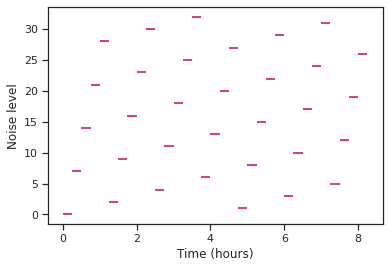

In [8]:
@plot
def plot_dataset(i_max: int):
    i_max = 33
    xmin = [ 0.25 * i for i in range(0, i_max) ]
    xmax = [ 0.25 * (i + 1) for i in range(0, i_max) ]
    y = [ (i * 7) % 33 for i in range(0, i_max) ]
    plt.hlines(y, xmin, xmax)
    plt.xlabel("Time (hours)")
    plt.ylabel("Noise level")

plot_dataset(33, output_pdf="interleave.pdf")

## Counting Data

In [8]:
ds = load_data(0, to_exclude)

In [9]:
print(f"Number of messages: {len(ds)}")
print("")
print("Count of 50 most common ID-cell pairs:")
id_cell = np.array(list(zip(ds.ids_array, ds.cells_array)))
np.sort(np.unique(id_cell, axis=0, return_counts=True)[1])[::-1][:50]

Number of messages: 35636

Count of 50 most common ID-cell pairs:


array([111, 105,  99,  99,  96,  94,  91,  90,  87,  87,  84,  82,  81,
        78,  74,  74,  73,  72,  71,  70,  70,  69,  68,  68,  68,  68,
        68,  68,  68,  67,  67,  65,  65,  64,  64,  63,  63,  63,  62,
        61,  61,  61,  61,  60,  60,  59,  58,  58,  58,  58])

In [9]:
dss = dict()
for noise in tqdm(range(0, 33)):
    dss[noise] = load_data(noise, to_exclude)

In [12]:
def get_id_cell(sat_id, sat_cell, num_cells=63):
    return sat_id * num_cells + sat_cell

id_cells = {
    noise: get_id_cell(dss[noise].ids_array, dss[noise].cells_array)
    for noise in dss.keys()
}

usable = [ np.sum(np.isin(id_cells[i], np.unique(id_cells[0]))) for i in sorted(id_cells.keys()) ]
usable_proportion = [ usable[i] / np.sum(id_cells[i]) for i in sorted(id_cells.keys()) ]

In [13]:
lens = [len(ds) for ds in dss.values()]
print(f"Total number of messages: {np.sum(lens)}")
df = pd.DataFrame({
    "Noise level": list(dss.keys()),
    "Total": lens,
    "Usable": usable,
})
df = df.melt(id_vars=["Noise level"], var_name="Type", value_name="Count")

Total number of messages: 540066


In [14]:
# Plot noise level (index of dataset) vs number of messages
@plot
def plot_num_messages(dss):
    lens = [len(ds) for ds in dss.values()]
    noises = list(dss.keys())
    ax = sns.lineplot(x=noises, y=lens)
    plt.xlabel("Noise level")
    plt.ylabel("Number of messages")

# Plot noise level (index of dataset) vs number of messages
@plot
def plot_num_messages_usable(dss, usable):
    lens = [len(ds) for ds in dss.values()]
    df = pd.DataFrame({
        "Noise level": list(dss.keys()),
        "Total": lens,
        "Usable": usable,
    })
    df.loc[df["Noise level"] == 0, "Usable"] = np.nan # Don't show 0 for usable
    df = df.melt(id_vars=["Noise level"], var_name="Type", value_name="Count")
    ax = sns.lineplot(data=df, x="Noise level", y="Count", hue="Type")
    ax.lines[1].set_zorder(-10) # Ensure the "Total" line appears on top in the z order
    plt.legend(title="")
    plt.ylabel("Number of messages")

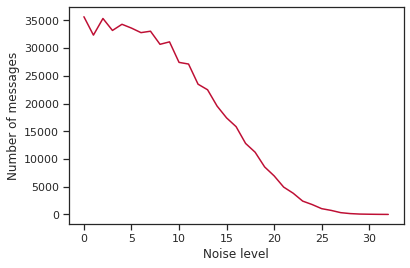

In [15]:
plot_num_messages(dss, output_pdf="num-messages.pdf")

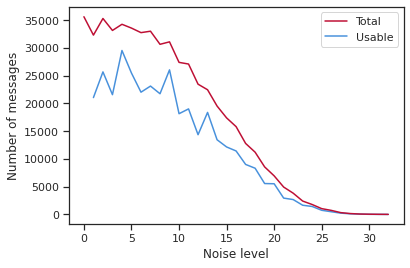

In [16]:
plot_num_messages_usable(dss, usable, output_pdf="num-messages-usable.pdf")

In [17]:
def get_id_cell(sat_id, sat_cell, num_cells=63):
    return sat_id * num_cells + sat_cell

def load_data(path, suffix):
    file_ids = os.path.join(path, f"ra_sat_{suffix}.npy")
    file_cells = os.path.join(path, f"ra_cell_{suffix}.npy")

    return np.load(file_ids), np.load(file_cells)

def load_data_all(path, suffixes):
    ids = []
    cells = []
    for suffix in suffixes:
        id_, cell = load_data(path, suffix)
        ids.append(id_)
        cells.append(cell)
    ids_array = np.concatenate(ids)
    cells_array = np.concatenate(cells)
    id_cells_array = get_id_cell(ids_array, cells_array)
    return ids_array, cells_array, id_cells_array

In [18]:
def get_id_cell(sat_id, sat_cell, num_cells=63):
    return sat_id * num_cells + sat_cell

@plot
def plot_distribution(ds: Database):
    id_cells_array = get_id_cell(ds.ids_array, ds.cells_array)
    id_counts = np.sort(np.unique(id_cells_array, return_counts=True)[1])

    ax = sns.histplot(id_counts, discrete=True, log_scale=(False, True))
    ax.set(xlabel='Number of Messages', ylabel='Number of Transmitters')

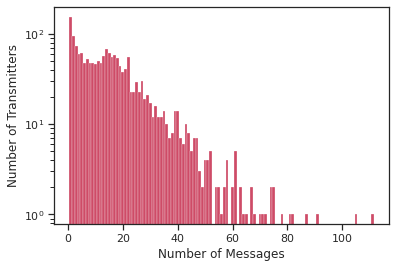

In [19]:
plot_distribution(dss[0], output_pdf="distribution.pdf")

# Plotting Samples

In [44]:
# Plot a single sample
@plot
def plot_sample(sample, figsize=5):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2*figsize, 1*figsize))
    ax = axs[0]
    x = np.arange(sample.shape[0], dtype=np.float64)
    x /= 25000000
    x *= 1e3
    ax.plot(x, sample[:,0], label='Real')
    ax.plot(x, sample[:,1], label='Imaginary')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper left')
    ax = axs[1]
    ax.plot(sample[:,0], sample[:,1])
    ax.set_xlabel('Amplitude (Real)')
    ax.set_ylabel('Amplitude (Imaginary)')
    fig.tight_layout()

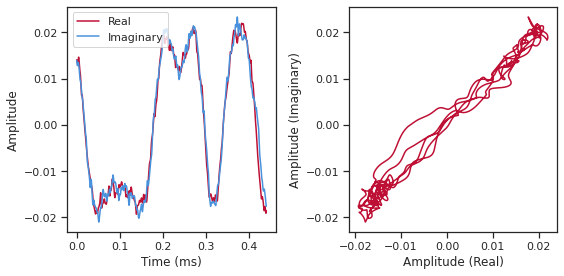

In [45]:
plot_sample(dss[0].samples_array[0], output_pdf="sample.pdf", figsize=4)

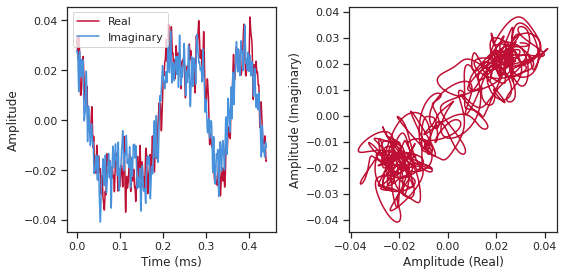

In [46]:
plot_sample(dss[32].samples_array[0], output_pdf="sample-noisy.pdf", figsize=4)

In [88]:
# Plot multiple samples side by side
@plot
def plot_sample_multiple(samples, noises, figsize=5):
    n = len(samples)
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(n*figsize, 1*figsize), sharex=True, sharey=True)
    for i in range(n):
        ax = axs[i]
        ax.plot(samples[i][:,0], samples[i][:,1])
        if i == 0:
            ax.set_ylabel('Amplitude (Imaginary)')
        ax.yaxis.label.set_size(16)

        #ax.set_title(f"Noise level: {noises[i]}")
        ax.set_title(f"$P_a/P_v = \!{noises[i]}\,$dB", size=16)
        #ax.title.set_size(16)

    # Set global x label
    fig.text(0.55, -0.01, 'Amplitude (Real)', ha='center', va='center', size=16)

    # Set x, y ticks
    for ax in axs.flatten():
        #ax.set_xticks([-0.02, -0.01, 0, 0.01, 0.02])
        #ax.set_yticks([-0.02, -0.01, 0, 0.01, 0.02])
        ax.set_xticks([-0.02, 0, 0.02])
        ax.set_yticks([-0.02, 0, 0.02])
        ax.tick_params(labelsize=14)

    fig.tight_layout()


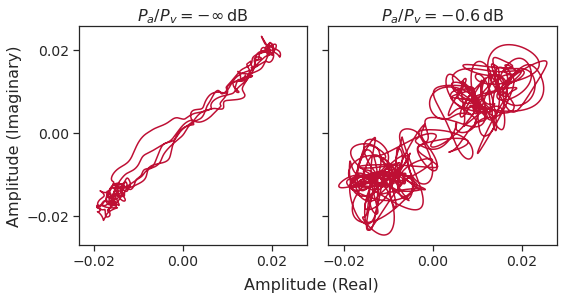

In [89]:
plot_sample_multiple(
    [dss[0].samples_array[0], dss[25].samples_array[0]],
    #[0, 25],
    ["-\!\infty", "-\!0.6"],
    figsize=4,
    output_pdf="sample-multiple.pdf"
)